In [27]:
# HELPER FUNCTION TO CALCULATE RATIO OF RETURN
# ratio of return in a monthly base
function get_monthly_return(csv_data)
    montly_return = Float64[]
    for i in 1:((size(csv_data))[1]-1)
        # use column 5(close price)
        # monthly return = (next month close price-this month close price)/this month close price
        append!(montly_return, (csv_data[i+1,5]-csv_data[i,5])/csv_data[i,5])
    end  
    return montly_return
end;    

In [28]:
using CSV, LinearAlgebra
# remove those files(not long enough) and get monthly return from all valid data files
data_files = readdir("top30")
total_monthly_return = zeros(215)
valid_data = zeros(216)

for i in data_files
    file_path = string("top30/", i)
    csv_data = CSV.read(file_path) 
    csv_length = (size(csv_data))[1]
    # check all csv has the same length (no new/removed S&P 500)
    if csv_length != 216
#         print(file_path, ": ")
#         println(csv_length)
    else
        # for valid data, get monthly return and append into array
        valid_data = hcat(valid_data, csv_data[:,5])        
        total_monthly_return = hcat(total_monthly_return, get_monthly_return(csv_data))
    end
end    

valid_data = valid_data[:, 2:end]
total_monthly_return = total_monthly_return[:, 2:end]
;

215×129 Array{Float64,2}:
  0.104819    -0.196552    -0.143617    …   0.743169   -0.0698691 
  0.184842     0.0300429    0.0248447       0.0384013   0.166667  
 -0.0865162    0.333333    -0.0363637      -0.115472    0.0905433 
 -0.322922     0.2125       0.201258        0.0392491  -0.134686  
  0.247024     0.278994    -0.17801         0.0845649  -0.0362474 
 -0.0298329    0.126449    -0.0445859   …  -0.0908403  -0.141593  
  0.199262     0.00536673  -0.0112529       0.184013    0.201674  
 -0.577436     0.338078    -0.023006       -0.0365682   0.0509393 
 -0.240292    -0.0757979    0.275362       -0.154015   -0.0204081 
 -0.15655      0.133813     0.159091       -0.461605    0.2       
 -0.0984845    0.0253807    0.17647     …   0.182692   -0.0833333 
  0.453782    -0.0528713   -0.00466662      0.170732    0.0915152 
 -0.15607      0.123144     0.00803746     -0.280093    0.0688506 
  ⋮                                     ⋱                         
  0.0477465    0.116255    -0.030449

In [29]:
using Statistics

# μ calculate mean of monthly return of a stock
function get_expected_monthly_return(total_monthly_return)
    expected_monthly_return = Float64[]
    for i in 1:size(total_monthly_return)[2]
        push!(expected_monthly_return, mean(total_monthly_return[:,i]))
    end
    return expected_monthly_return
end

# Σ convolution between stocks
function get_cov_matrix(total_monthly_return, expected_monthly_return)
    return transpose(total_monthly_return)*total_monthly_return./size(total_monthly_return)[2]
    -expected_monthly_return*transpose(expected_monthly_return)
end
;

In [30]:
# risk favorite data in 15 years and 10 years
risk_favorite = CSV.read("data/risk_favorite.csv")
risk_favorite_15 = mean(risk_favorite[2:180,2])/100

0.03803351955307261

In [31]:
risk_favorite_10 = mean(risk_favorite[62:180,2])/100

0.03317899159663869

In [32]:
# S&P 500 index data in 15 years and 10 years
index_data = CSV.read("data/index.csv")
index_monthly_return_15 = get_monthly_return(index_data[1:180,:])
index_monthly_return_10 = get_monthly_return(index_data[61:180,:])
;

In [33]:
# HELPER FUNCTION TO CALCULATE RATIO OF RETURN
# # mean of monthly return of a stock in a monthly base
function get_monthly_return_stock(stock_data)
    montly_return = Float64[]
    for i in 1:((size(stock_data))[1]-1)
        append!(montly_return, (stock_data[i+1,1]-stock_data[i,1])/stock_data[i,1])
    end  
    return montly_return
end
;    

In [34]:
# number of timing slots and number of stock
num_time_period = size(total_monthly_return)[1]
num_stock = size(total_monthly_return)[2]

# μ mean of monthly return of a stock of all data
expected_monthly_return = get_expected_monthly_return(total_monthly_return)
;

In [35]:
# Σ convolution between stocks of all data
cov_matrix = get_cov_matrix(total_monthly_return, expected_monthly_return)
;

In [37]:
# calculate monthly return in 15 years
length_15 = 180-1
total_monthly_return_15 = total_monthly_return[1:length_15,:]
;

In [38]:
# calculate expected monthly return and covariance matrix in 15 years
expected_monthly_return_15 = get_expected_monthly_return(total_monthly_return_15)
cov_matrix_15 = get_cov_matrix(total_monthly_return_15, expected_monthly_return_15)
;

In [39]:
# slove model for 2000-2015 risk-favorite based basseline profit
baseline_profit = risk_favorite_15
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)
# minimize the risk while maintain the baseline profit
@objective(m, Min, dot(w,cov*w) )

status = solve(m)
println(status) 
xsol_15rf = getvalue(w)
;

Optimal


In [40]:
# slove model for 2000-2015 index-based basseline profit
baseline_profit = mean(index_monthly_return_15)
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
# minimize the risk while maintain the baseline profit
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol_15id = getvalue(w)
;

Optimal


In [41]:
# slove model for 2000-2015 equally-weighted based basseline profit
baseline_profit = mean(expected_monthly_return_15)
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
# minimize the risk while maintain the baseline profit
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol_15eq = getvalue(w)
;

Optimal


In [44]:
# calculate monthly return in 10 years
length_10 = 180-60-1
total_monthly_return_10 = total_monthly_return[1:length_10, :]
;

In [45]:
# calculate expected monthly return and covariance matrix in 10 years
expected_monthly_return_10 = get_expected_monthly_return(total_monthly_return_10)
cov_matrix_10 = get_cov_matrix(total_monthly_return_10, expected_monthly_return_10)
;

In [46]:
# slove model for 2005-2015 risk-favorite based  basseline profit
baseline_profit = risk_favorite_10
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)
# minimize the risk while maintain the baseline profit
@objective(m, Min, dot(w,cov*w) )

status = solve(m)
println(status) 
xsol_10rf = getvalue(w)
;

Optimal


In [47]:
# slove model for 2000-2015 index based basseline profit
baseline_profit = mean(index_monthly_return_10)
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)
# minimize the risk while maintain the baseline profit
@objective(m, Min, dot(w,cov*w) )

status = solve(m)
println(status) 
xsol_10id = getvalue(w)

Optimal


129-element Array{Float64,1}:
  0.07939430024302181  
  0.1834225457221843   
  0.014353807861033421 
 -0.2988024408221237   
 -0.11865626290820601  
  0.007511951773548264 
 -0.09219376098036519  
 -0.17243583701049087  
  0.0054606357303143   
 -0.0036908810498837053
  0.03299743068184907  
 -0.15402464938851546  
  0.14419318749613783  
  ⋮                    
 -0.1260733530971492   
 -0.0039595252407670705
  0.06835081996677402  
  0.34232248805175236  
  0.2580737727924238   
 -0.0688742439209144   
  0.01455818635222657  
 -0.04962129105606472  
  0.15431385449362725  
  0.3650066071651921   
 -0.13212342526213422  
 -0.001140288301603878 

In [48]:
# 2005-2015 equally weighted
baseline_profit = mean(expected_monthly_return_10)
# baseline_profit = sum(expected_monthly_return_10)/length_10
mT = transpose(expected_monthly_return_10)
cov = cov_matrix_10

using JuMP, Gurobi, Ipopt
# m = Model(solver=GurobiSolver(OutputFlag=0))
m = Model(solver=IpoptSolver(print_level=0))
@variable(m, w[1:num_stock] >= 0)
@objective(m, Min, dot(w,cov*w) )
@constraint(m, mT*w >= baseline_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol_10eq = getvalue(w)
;

Optimal


In [21]:
using JuMP, Gurobi
# solve linear regression problem
function linear_regression(r_stock, r_m)
    m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
    @variable(m, u[1:2])
    # Using LEAST SQUARE
    # r_stock = b*r_market + a
    @objective(m, Min, sum( (r_stock - (r_m*u[2]+u[1])).^2 ) )
    status = solve(m)
    uopt = getvalue(u)
    err_term = getobjectivevalue(m)
    # return b and err_term
    return uopt[2], err_term
end

linear_regression (generic function with 1 method)

In [26]:
function getTestValue(weight)
    test_monthly_return = Float64[]
    #sum = 0
    # replace low-percentage stock by 0
    for i in 1:num_stock
        if abs(weight[i]) < 0.001
     #       sum += weight[i]
            weight[i] = 0
            
        end
    end
        
    test_sample = total_monthly_return[182:215, :]
    final_result = test_sample * weight
    
    final_tracking = Float64[]
    final_return = 1
    for i in final_result
        push!(final_tracking,final_return)
        final_return *= i+1
    end
    
    final_variance = var(final_result, corrected = false)
    
    return final_result,final_tracking, final_variance
end

getTestValue (generic function with 1 method)

In [27]:
file_path = "data/^GSPC.csv"
sp500_data = CSV.read(file_path)
sp500_monthly_return = get_monthly_return(sp500_data)
sp500_compare_data = sp500_monthly_return[182:215]
;

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = __init__() at init.jl:175
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/init.jl:175
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = find_backend(::PyCall.PyObject) at init.jl:73
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/init.jl:73
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = find_backend(::PyCall.PyObject) at init.jl:129
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/init.jl:129
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in fav

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = showable(::MIME{Symbol("image/png")}, ::Figure) at PyPlot.jl:81
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:81
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base64.Base64EncodePipe}, ::MIME{Symbol("image/png")}, ::Figure) at PyPlot.jl:73
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:73


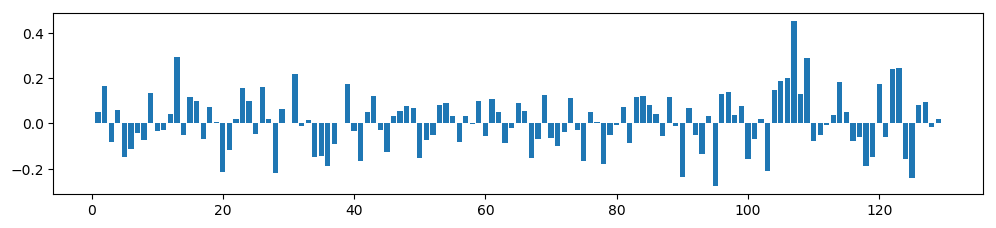

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base64.Base64EncodePipe}, ::MIME{Symbol("image/png")}, ::Figure) at PyPlot.jl:73
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:73
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base64.Base64EncodePipe}, ::MIME{Symbol("image/png")}, ::Figure) at PyPlot.jl:77
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:77
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base64.Base64EncodePipe}, ::MIME{Symbol("i

In [28]:
using PyPlot
fr_15rf, ft_15rf, fv_15rf = getTestValue(xsol_15rf);
(solution, final_result, final_tracking) = (xsol_15rf, fr_15rf, ft_15rf);
x = range(1,stop = 129)
fig = figure("pyplot_barplot",figsize=(12,8))
subplot(311)
bar(x,solution)
# bar(x,solution,color="#0f87bf",align="center",alpha=0.4)
# xlabel("stock number")
# ylabel("weight")

# figure(figsize=(12,8))
# subplot(312)
# plot([sp500_compare_data final_result],".-");
# legend(["sp-500", "our portfolio"], loc="lower right")
# ylim(-0.2, 0.2)

# x = range(1,stop = 34)
# figure(figsize=(12,8))
# subplot(313)
# plot(x, final_tracking,".-");
# legend(["our portfolio tracking"], loc="lower right")

In [29]:
function threePlots(solution, final_result, final_tracking)
    x = range(1,stop = 129)
    fig = figure("pyplot_barplot",figsize=(12,8))
    subplot(311)
    bar(x,solution,color="#0f87bf",align="center",alpha=0.4)
    xlabel("stock number")
    ylabel("weight")
    
    figure(figsize=(12,8))
    subplot(312)
    plot([sp500_compare_data final_result],".-");
    legend(["sp-500", "our portfolio"], loc="lower right")
    ylim(-0.2, 0.2)

    x = range(1,stop = 34)
    figure(figsize=(12,8))
    subplot(313)
    plot(x, final_tracking,".-");
    legend(["our portfolio tracking"], loc="lower right")
end

threePlots (generic function with 1 method)

┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasproperty(o, s)` instead.
│   caller = #bar#19(::Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:color, :align, :alpha),Tuple{String,String,Float64}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:176
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:176
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #bar#19(::Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:color, :align, :alpha),Tuple{String,String,Float64}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:179
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:179
┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasprope

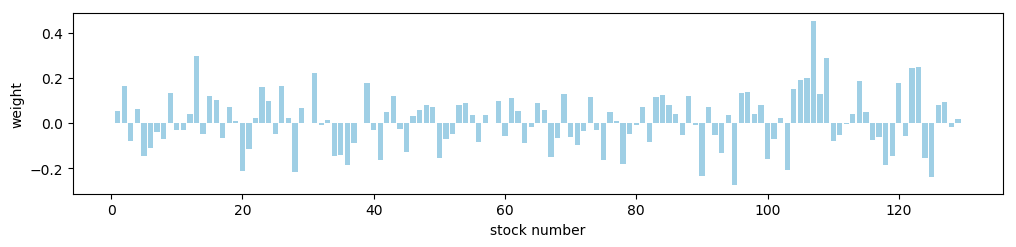

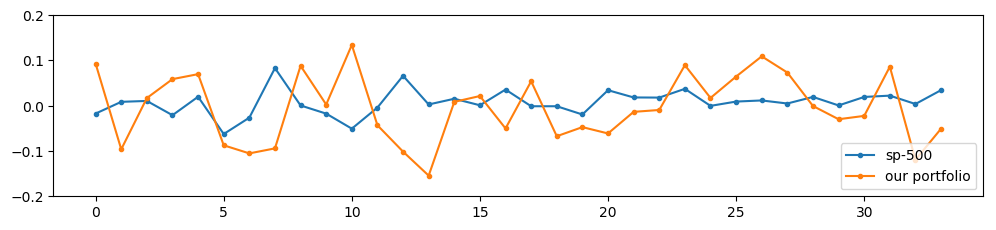

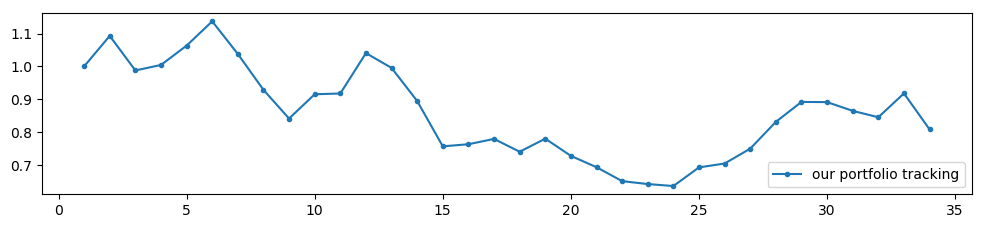

┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasproperty(o, s)` instead.
│   caller = #plot#85(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:176
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:176
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #plot#85(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::UnitRange{Int64}, ::Vararg{Any,N} where N) at PyPlot.jl:179
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:179


In [30]:
using PyPlot
fr_15rf, ft_15rf, fv_15rf = getTestValue(xsol_15rf);
threePlots(xsol_15rf, fr_15rf, ft_15rf);

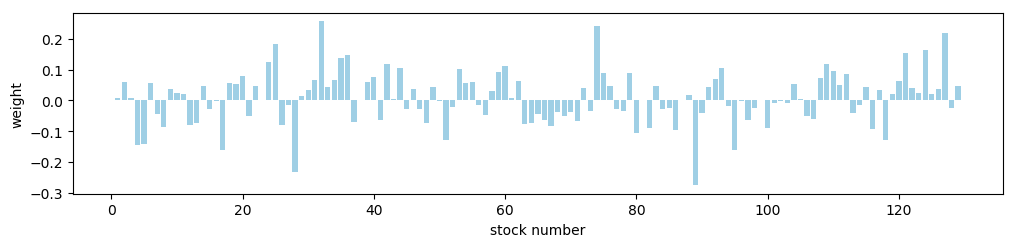

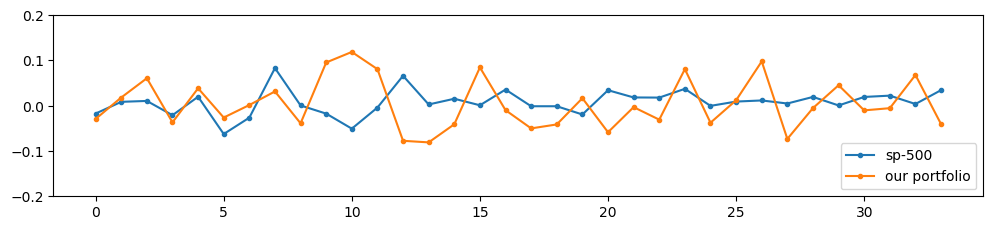

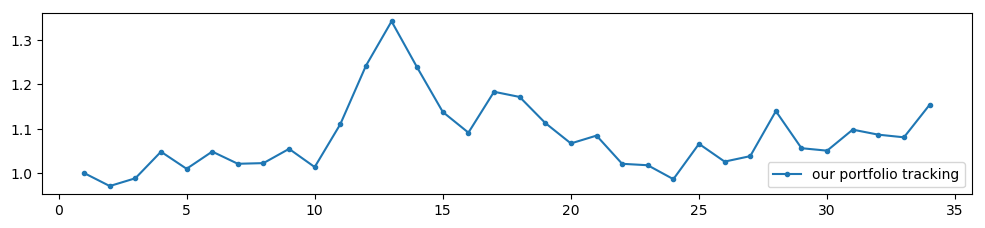

In [31]:
fr_15id, ft_15id, fv_15id = getTestValue(xsol_15id);
threePlots(xsol_15id, fr_15id, ft_15id);

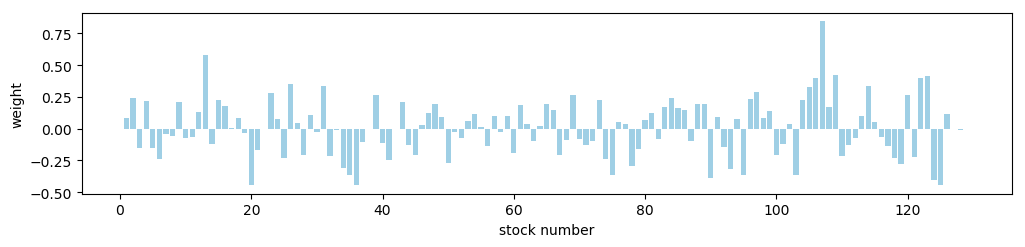

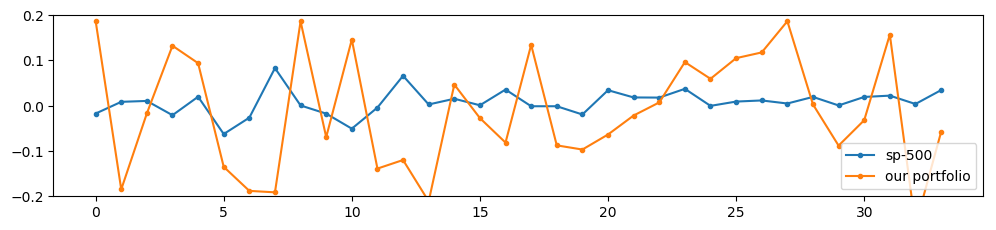

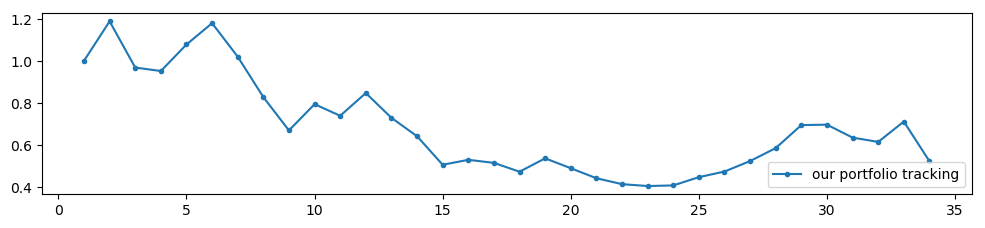

In [32]:
fr_15eq, ft_15eq, fv_15eq = getTestValue(xsol_15eq);
threePlots(xsol_15eq, fr_15eq, ft_15eq);

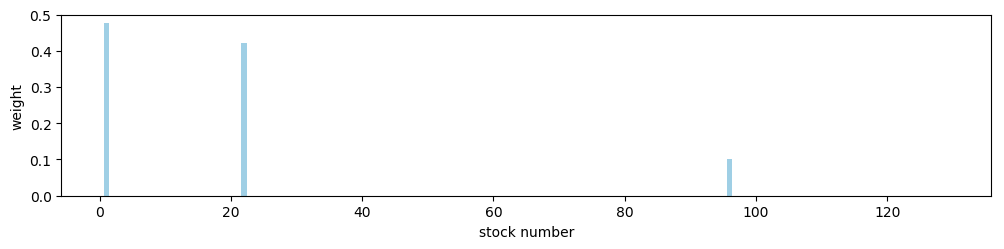

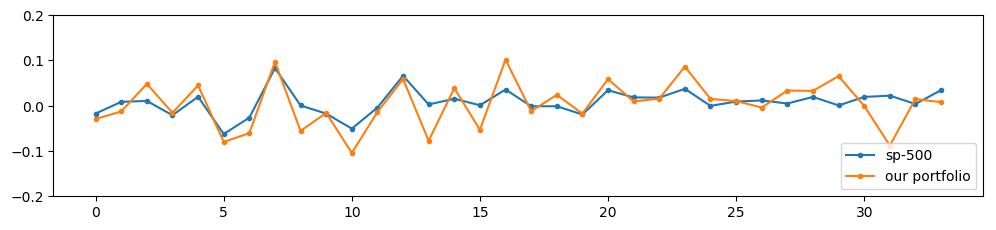

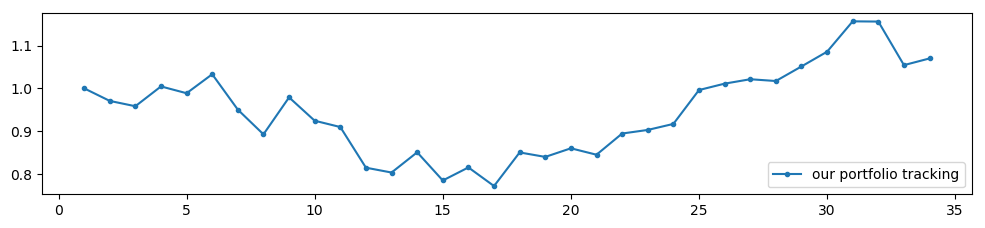

In [33]:
#
fr_10rf, ft_10rf, fv_10rf = getTestValue(xsol_10rf);
threePlots(xsol_10rf, fr_10rf, ft_10rf);

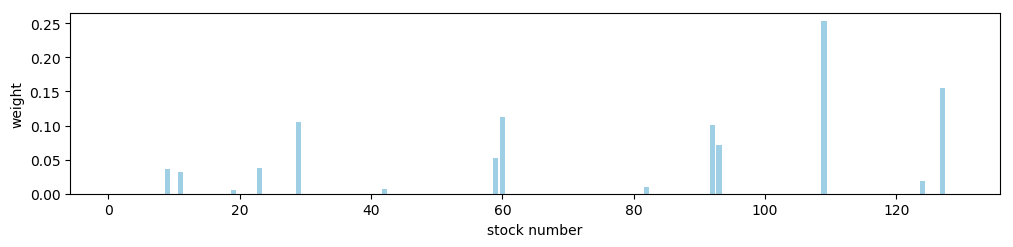

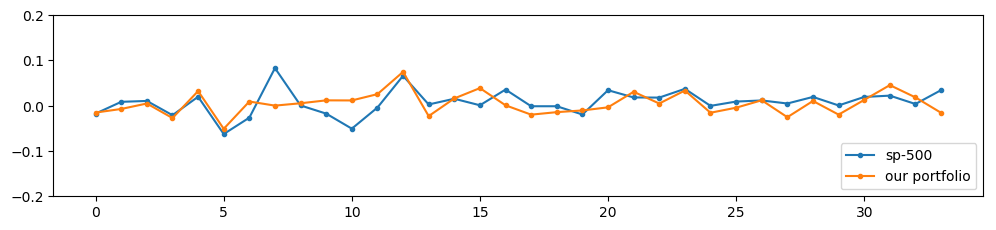

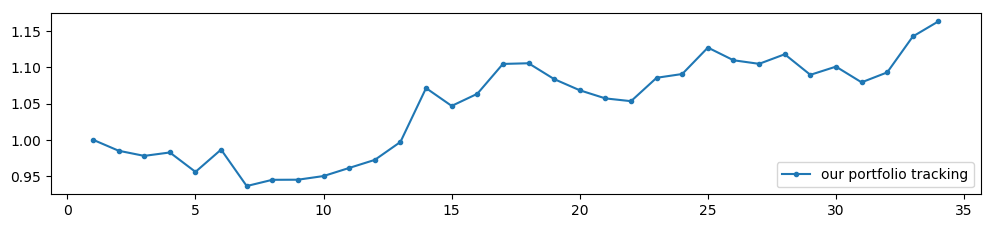

In [34]:
fr_10id, ft_10id, fv_10id = getTestValue(xsol_10id);
threePlots(xsol_10id, fr_10id, ft_10id);

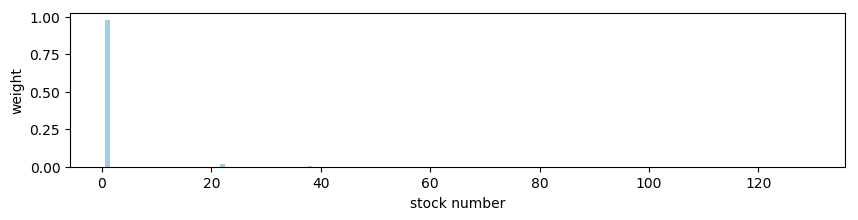

┌ Warning: `haskey(o::PyObject, s::Union{Symbol, AbstractString})` is deprecated, use `hasproperty(o, s)` instead.
│   caller = #subplot#112(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function) at PyPlot.jl:176
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:176
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #subplot#112(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function) at PyPlot.jl:179
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:179


In [35]:
x = range(1,stop = 129)
fig = figure("pyplot_barplot",figsize=(10,2))
subplot()
bar(x,xsol_10eq,color="#0f87bf",align="center",alpha=0.4)
xlabel("stock number")
ylabel("weight")
;

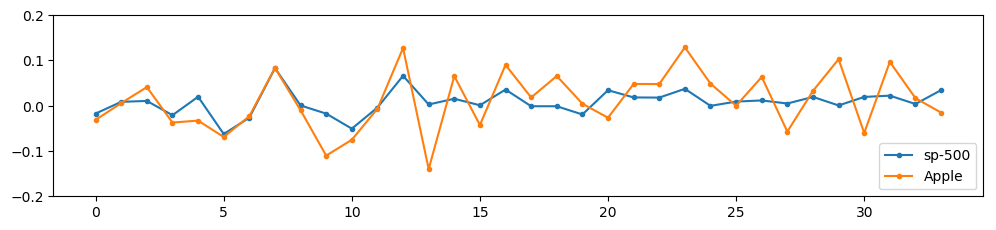

In [36]:
figure(figsize=(12,8))
subplot(312)
plot([sp500_compare_data total_monthly_return[182:215,1]],".-");
legend(["sp-500", "Apple"], loc="lower right")
ylim(-0.2,0.2)
;

In [37]:
println(fv_15rf)
println(fv_15id)
println(fv_15eq)
println(fv_10rf)
println(fv_10id)
println(fv_l1)
println(fv_rb)

0.005502694335338783
0.002992673399402798
0.016131596621516486
0.00265457296352442
0.0005919340021730444


UndefVarError: UndefVarError: fv_l1 not defined

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = close_figs() at PyPlot.jl:130
└ @ PyPlot /Users/zhengxianjie/.julia/packages/PyPlot/fZuOQ/src/PyPlot.jl:130


## 3.3

In [38]:
# 2000-2015 index baseline profit as target profit
target_profit = mean(index_monthly_return_15)
mT = transpose(expected_monthly_return_15)
cov = cov_matrix_15
# regularization factor
tune_factor = 120

using JuMP, Gurobi, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
# t as the absolute value of w
@variable(m, t[1:num_stock])
@constraint(m,  w .<= t)
@constraint(m, -w .<= t)
@constraint(m,  t .<= 1)
@constraint(m,w[38] == 0)
@constraint(m, mT*w == target_profit )
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)
# introduce L1 regularization
@objective(m, Min, sum([target_profit - (transpose(total_monthly_return_15[t,:])*w)^2 for t in 1:length_15]) + tune_factor*sum(t) )

status = solve(m)
println(status) 
xsol_l1 = getvalue(w)

Optimal


129-element Array{Float64,1}:
  9.83212210310953e-11  
  1.531572604698296e-11 
 -6.904815910259833e-12 
 -3.285536875268782e-11 
 -4.0976822966470575e-11
  3.865557962746567e-13 
 -1.9424632189068215e-11
  1.450256792505008e-11 
  6.855159976110675e-12 
  1.6081961921881625e-11
 -1.138631517089771e-11 
 -1.088128676389204e-11 
  1.8428902099271865e-11
  ⋮                     
 -1.4020165290468329e-11
 -1.7530623550430738e-11
  1.0553119100479518e-11
 -1.3517317565616375e-11
  4.679538672418592e-12 
  2.1890044029076808e-11
 -1.0078850282872852e-10
 -8.946543450210813e-12 
 -6.778893493737596e-12 
 -5.255712002559593e-11 
 -2.535882269215538e-11 
  3.0257104953474487e-12

In [39]:
for i in 1:num_stock
    if abs(xsol_l1[i]) > 0.01
        println(i)
        println(xsol_l1[i])
    end
end

20
-0.05313196835050708
22
0.05313194988613684
70
1.000000019902043


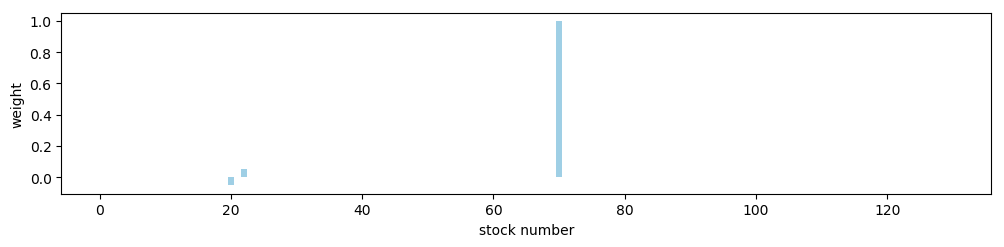

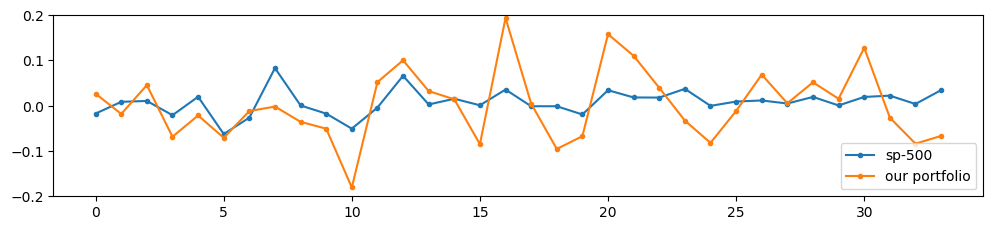

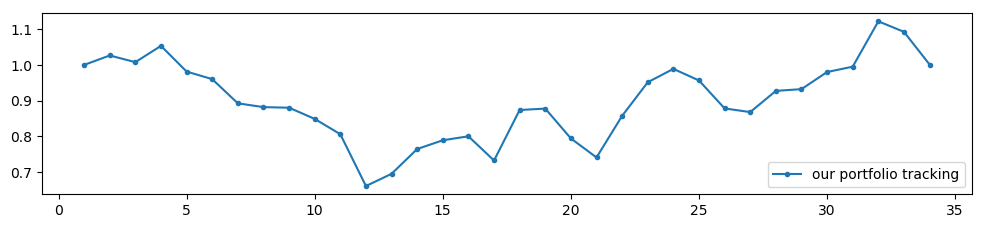

In [40]:
#
fr_l1, ft_l1, fv_l1 = getTestValue(xsol_l1);
threePlots(xsol_l1, fr_l1, ft_l1);

## 3.2

In [51]:
using JuMP, Gurobi
# solve the linear regression problem
function linear_regression(r_stock, r_m)
    m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
    @variable(m, u[1:2])
    # using LEAST SQUARE fit r_stock = b * r_market + a
    @objective(m, Min, sum( (r_stock - (r_m*u[2]+u[1])).^2 ) )
    status = solve(m)
    uopt = getvalue(u)
    return uopt
end

linear_regression (generic function with 1 method)

In [52]:
# variance for index monthly return
var_index = var(index_monthly_return_15, corrected=false)
b_vec = Float64[]
expected_monthly_return_removed = Float64[]
var_err_stock = Float64[]
mean_err_stock = Float64[]
for stock in 1:num_stock
    # remove 9(5%) extreme values of each stock
    monthly_return_stock = total_monthly_return[1:length_15,stock]
    # calculate the square of the distance between this month return and mean
    # sort and remove highest distance from mean
    mean_15 = mean(monthly_return_stock)
    distance_15 = [(i-mean_15)^2 for i in monthly_return_stock]
    remove_h = sort(distance_15, rev=true)[1:9]
    remove_h_index_all = [findall(x -> x== i, distance_15) for i in remove_h]
    remove_h_index = collect(Iterators.flatten(remove_h_index_all))
    new_monthly_return_stock = Float64[]
    new_index_monthly_return = Float64[]
    # remove corresponding data from both monthly return of stock and index monthly return
    for i in 1:length_15
        if !(i in remove_h_index)
            append!(new_monthly_return_stock, monthly_return_stock[i])
            append!(new_index_monthly_return, index_monthly_return_15[i])
        end
    end
    append!(expected_monthly_return_removed, mean(new_monthly_return_stock))
    # calculate the linear regression
    a = linear_regression(new_monthly_return_stock, new_index_monthly_return)
    append!(b_vec, a[2])
    # calculate the error term of the linear regreesion of the stock and market
    err = new_monthly_return_stock - (new_index_monthly_return.*a[2].+a[1])
    # mean and variance of the error term
    append!(var_err_stock, var(err))
    append!(mean_err_stock, mean(err))
end
;

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [54]:
# calculate the covariance between two stocks
cov_stock = transpose(zeros(num_stock))
for i in 1:num_stock
    cov_stock = vcat(cov_stock, transpose([b_vec[i]*b_vec[j]*var_index for j in 1:num_stock]))
end

cov_stock = cov_stock[2:end, :]
;

In [55]:
# adding a bias-correction term
cov_stock = cov_stock .+ (length_15-1)/(length_15-2).*Diagonal(mean_err_stock)
;

In [57]:
# 2000-2015 risk favorite remove 5% extreme values using index baseline profit
baseline_profit = mean(index_monthly_return_15)
# baseline_profit = sum(expected_monthly_return_15)/length_15
mT = transpose(expected_monthly_return_removed)
cov = cov_stock

using JuMP, Ipopt
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, w[1:num_stock])
@objective(m, Min, dot(w,cov*w) )
@constraint(m, w[38] == 0)
@constraint(m, mT*w >= baseline_profit )
# minimize the risk while maintain the baseline profit
@constraint(m, sum(w[i] for i in 1:num_stock) == 1)

status = solve(m)
println(status) 
xsol_rb = getvalue(w)
;

Optimal


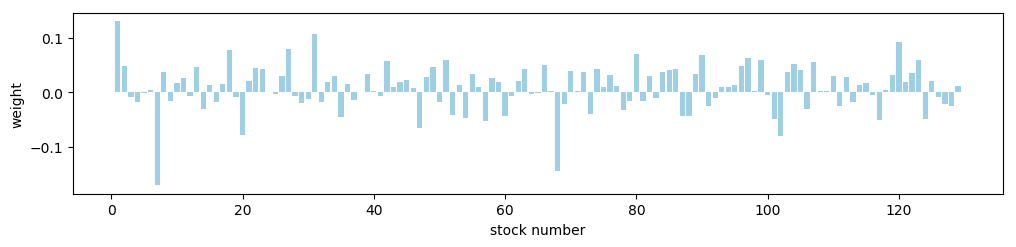

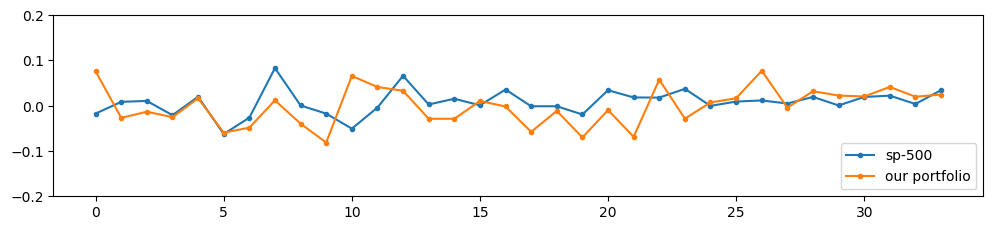

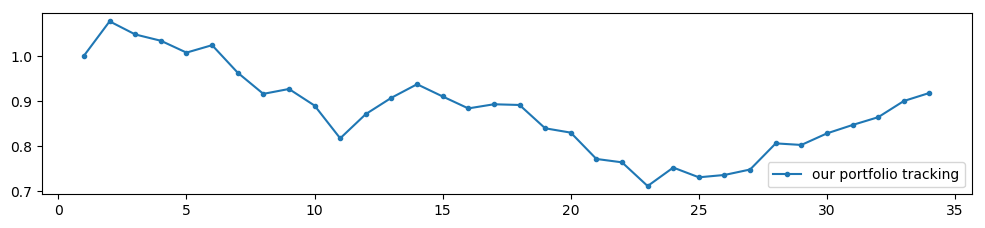

In [49]:
#
fr_rb, ft_rb, fv_rb = getTestValue(xsol_rb);
threePlots(xsol_rb, fr_rb, ft_rb);

In [50]:
ft_rb

34-element Array{Float64,1}:
 1.0               
 1.0759160071304903
 1.046938722335505 
 1.0329987367256201
 1.0067758099422714
 1.0232395856593395
 0.9623502362207438
 0.915581452862094 
 0.9263893495812685
 0.8896705305063098
 0.8172651961746368
 0.8709082726339642
 0.9069550161991813
 ⋮                 
 0.7117944674962103
 0.7526262986103034
 0.7311070327641738
 0.7362833950820294
 0.7483570942415068
 0.8061005021890153
 0.8026425234708394
 0.828233045358111 
 0.8467906059586556
 0.8640175709853475
 0.8997864633957373
 0.9176302381107336